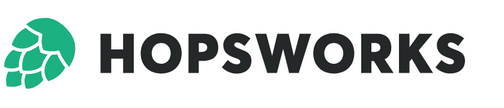


# Part 03: Model training & UI Exploration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_online/3_model_training.ipynb)

In this last notebook, we will train a model on the dataset we created in the previous tutorial. We will train our model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. We will also show some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 5 main sections:
1. **Loading the training data**
2. **Train the model**
3. **Register model to Hopsworks model registry**.
4. **Deploy the model on KServe behind Hopsworks for real-time inference requests**.
5. **Test model deployment and use model serving rest APIs**.

![tutorial-flow](../images/03_model.png)

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

---

## <span style="color:#ff5f27;"> ⬇️ Training Dataset retrieval</span>

To retrieve training dataset from **Feature Store** we retrieve **Feature View** using `FeatureStore.get_feature_view` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_training_dataset` method.


In [ ]:
nyc_fares_fv = fs.get_feature_view(
    name = 'nyc_taxi_fares',
    version = 1
)

In [ ]:
X_train, y_train, X_test, y_test = nyc_fares_fv.get_train_test_split(
    training_dataset_version=2
)

In [ ]:
cols_to_drop = ['pickup_datetime', 'ride_id', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

In [ ]:
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
import numpy as np


y_train, y_test = np.ravel(y_train), np.ravel(y_test)

In [ ]:
y_test

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

#### <span style="color:#ff5f27;"> 📝 Importing Libraries</span>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score

---

### <span style="color:#ff5f27;"> ⚜️ Weights and Biases </span>

[Weights and Biases](https://wandb.ai/) is a free Python library that allows you to track, compare, and visualize ML experiments -> build better models faster. 

In our case we will use **W&B** to track Data Lineage using **Artifacts**, find the best hyperparameters using **Sweep** and visualize model performance.

To begin with, let's install `wandb` library.

In [ ]:
!pip install wandb --quiet

In [ ]:
import wandb
wandb.login()

---

### <span style="color:#ff5f27;"> 🗃 W&B Artifacts </span>

Use W&B Artifacts for dataset versioning, model versioning, and tracking dependencies and results across machine learning pipelines. Think of an artifact as a versioned folder of data. You can store entire datasets directly in artifacts, or use artifact references to point to data in other systems like S3, GCP, or your own system. 

Also you can visualize Data Lineage for better understanding of project pipeline.

In [ ]:
PROJECT_NAME = 'nyc_taxi_fares'

In [ ]:
# create a run in W&B

run = wandb.init(
    project=PROJECT_NAME,
    job_type="upload_feature_view",
    name='metadata'
)

In [ ]:
# create an artifact for all the raw data
raw_data_at = wandb.Artifact(
    name="nyc_fares_fv", 
    type="feature_view",
    metadata = {key:value.__repr__() for key,value in nyc_fares_fv.to_dict().items()}
)

# save artifact to W&B
run.log_artifact(raw_data_at)

In [ ]:
run = wandb.init(
    project=PROJECT_NAME,
    name="train_validation_test_split",
    job_type='split'
)

data_at = run.use_artifact("nyc_fares_fv:latest")
data_dir = data_at.download()

artifacts = {}

for split in ['train','validation','test']:
    artifacts[split] = wandb.Artifact(f'{split}_split', type="split")  
    
for split, artifact in artifacts.items():
    run.log_artifact(artifact)

To check Data Lineage follow next steps:

1. Go to the [W&B main page](https://wandb.ai/home).

2. Select **"nyc_taxi_fares"** project.

3. Select the **"Artifacts"** icon in the left sidebar.

4. Inspect the `nyc_fares_fv` type artifact.

5. Go to the **"Lineage"** and then press **"Explode"**.

So for now Data Lineage should look like this:

![image.png](../images/wandb_lineage.png)

---

### <span style="color:#ff5f27;">🏋️‍♀️  Define Model Training Function</span>

It is important to define a function which will be used by the [Sweep agent](https://docs.wandb.ai/guides/sweeps/python-api).

In this function we:

- Set default hyperparameters for the model.

- Initialize a new W&B Run using `wandb.init`.

- Register all hyperparameters through `wandb.config`.

- Create a RandomForestClassifier with a set of hyperparameters.

- Fit a RandomForestClassifier.

- Predict and evaluate.

- Log all metrics using `wandb.log`.

- Plot beautiful plots using `wandb.sklearn.plot_classifier`.

In [ ]:
def train_model():
    # Set default configurations (Defaults will be overwritten during sweep)
    config_defaults = {
      'max_depth': 3, 
      'n_estimators': 50
    }

    # Start W&B
    wandb.init(config=config_defaults)
    config = wandb.config

    # Fit regression model on train set
    model = RandomForestRegressor(
      max_depth=config.max_depth,
      n_estimators=config.n_estimators
    )
    model.fit(X_train, y_train)

    # Predict on test set
    y_preds = model.predict(X_test)

    # Evaluate predictions
    mae_score = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)
    print(f"MAE: {round(mae_score, 4)}, R²: {round(r2, 2)}")

    # Log model performance metrics to W&B
    wandb.log({"mae": mae_score, "r2_score": r2})
    
    # wandb.sklearn.plot_regressor(model, X_train, X_test, y_train, y_test, model_name='RandomForestRegressor')

---

### <span style="color:#ff5f27;"> 🔧 Define Sweep Configurations</span>

The next step is to define configurations for Sweep.

**Weights & Biases Sweeps** are used to automate hyperparameter optimization and explore the space of possible models.

You will initialize Sweep in form of a dictionary.

You should include next steps:

- `method`: specify your search strategy (**bayesian**, **grid** and **random** searches.)

- `metric`: define the name and goal (maximize or minimize) of the metric. **Example**:
        name: mae,
        goal: minimize

- `parameters`: define the hyperparameters as the keys of a dictionary and their corresponding values to search over in the form of a list stored as the values of this dictionary.

In [ ]:
sweep_configs = {
    "method": "random",
    "metric": {
        "name": "mae",
        "goal": "minimize"
    },
    "parameters": {
        "max_depth": {
            "values": [4, 6, 8, 10]
        },
        "n_estimators": {
            "values": [200, 350, 500, 800]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configs, project=PROJECT_NAME)

In [ ]:
wandb.agent(sweep_id=sweep_id, function=train_model, count=5)

### <span style="color:#ff5f27;">🎉 Great! 📈</span>

Now you can go to the **Weights & Biases** UI to look at the results

There you can find some great plots which will help you to control model development process such as **Feature Importance**, **ROC Curve**, **Confusion Matrix** and others.

### <span style="color:#ff5f27;">🚀 Find the best model</span>

![image.png](../images/wandb_table.png)

### After sorting by *mae* column, we see that the best hyperparameters are:
    - max_depth: 10
    - n_estimators: 800

In [ ]:
# lets train our model using that params
rf_model = RandomForestRegressor(
    max_depth=10,
    n_estimators=800,
    n_jobs = -1,
    random_state = 42
)

rf_model.fit(X_train, y_train)

In [ ]:
rf_preds = rf_model.predict(X_test)

rf_r2_score = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

print("Random Forest Regressor R²:", rf_r2_score)
print("Random Forest Regressor MAE:", rf_mae)

In [ ]:
sns.residplot(y_test, rf_preds, color='#613F75')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()

The Random Forest did a better job, so we will register this specific model.

---
### <span style="color:#ff5f27;">🔮 Saving Model in W&B</span>

In [ ]:
import joblib

run = wandb.init(project="fraud_batch", job_type="model_building", name = 'classifier') 

data_at = run.use_artifact("train_split:latest")
data_dir = data_at.download()

model_artifact = wandb.Artifact(
            "RandomForestRegressor", type="model",
            description="This model is trained on the data from  `Hopsworks  Feature View`.\
                You can check it on the https://app.hopsworks.ai.\
                Just Login and go to the `Feature Views` page and find **nyc_fares_fv**.",
            metadata=dict(sweep_configs))

joblib.dump(clf, "model.joblib")

model_artifact.add_file("model.joblib")

wandb.save("model.joblib")

run.log_artifact(model_artifact)

## <span style="color:#ff5f27;">📝 Register model</span>

One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Let's connect to the model registry using the [HSML library](https://docs.hopsworks.ai/machine-learning-api/latest) from Hopsworks.

In [ ]:
mr = project.get_model_registry()

Before registering the model we will export it as a pickle file using joblib.

In [ ]:
import joblib

joblib.dump(rf_model, 'model.pkl')

### <span style="color:#ff5f27;">⚙️ Model Schema</span>



The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

With the schema in place, we can finally register our model.

In [ ]:
metrics = {
    'mae': rf_mae,
    'r2_score': rf_r2_score
}


In [ ]:
model = mr.sklearn.create_model(
    name="nyc_taxi_fares_model",
    metrics=metrics,
    description="Random Forest Regressor.",
    input_example=X_train.sample(),
    model_schema=model_schema
)

model.save('model.pkl')

Here we have also saved an input example from the training data, which can be helpful for test purposes.

It's important to know that every time you save a model with the same name, a new version of the model will be saved, so nothing will be overwritten. In this way, you can compare several versions of the same model - or create a model with a new name, if you prefer that.

In [ ]:
model = mr.get_model("nyc_taxi_fares_model", version = 1)

## <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> 🚀 Model Deployment</a>

In [ ]:
%%writefile predict_example.py
import os
import hsfs
import joblib
import numpy as np
import pandas as pd

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

In [ ]:
import os


dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

In [ ]:
# On cluster, I have created this file manually cause it was not creating by itself

# predictor_script_path = f'hdfs:///Projects/{fs.project_name}/Jupyter/predict_example.py'

In [ ]:
predictor_script_path

In [ ]:
# Give it any name you want
deployment = model.deploy(
    name="nyctaxifares", 
    model_server="PYTHON",
    script_file=predictor_script_path,
#     serving_tool = "KSERVE"
)

In [ ]:
print("Deployment: " + deployment.name)
deployment.describe()

### The deployment has now been registered. However, to start it you need to run:

In [ ]:
deployment.start()

In [ ]:
deployment.get_logs()

## <span style='color:#ff5f27'>🔮 Predicting using deployment</span>

In [ ]:
model.input_example

In [ ]:
data = {
    "inputs": model.input_example
}

deployment.predict(data)

In [ ]:
deployment.stop()